# Disaster Tweets Natural Language Processing 

https://github.com/rrazz247/NLP-tweets

### 1. Problem description

The goal of this project is to analyze tweets and determine if they are about real disasters or not. So, this is a binary classification problem, and I will use a neural network to solve it.

The dataset contains columns for `id`, `keyword`, `location`, `text`, and `target`, which is labeled 0 (no disaster) or 1 (disaster).

The train dataset contains 7,613 tweets, while the test dataset has 3,263 tweets.

### 2. Exploratory Data Analysis

First, I will load the libraries and load the data.

In [89]:
# Load libraries

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
# Load data

train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
print(train_df.info())
print("-------")
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
-------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


From the above summary output, we can see that there are many null entries in the `keyword` and `location` columns. I will replace these null values with `''`.

In [6]:
train_df['keyword'] = train_df['keyword'].fillna('')
train_df['location'] = train_df['location'].fillna('')


First, I will examine the proportion of disaster tweets out of all tweets. The bar graph below shows that there are about 1000 fewer disaster tweets than non-disaster, but there are still plenty of examples from each group. I do not anticipate that class imbalance will be an issue here.

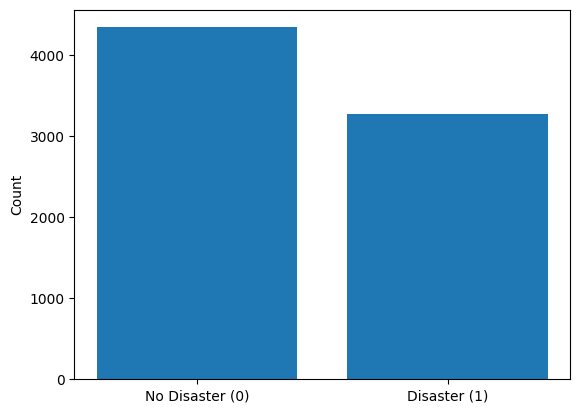

In [57]:
target_counts = train_df['target'].value_counts()

plt.bar(target_counts.index, target_counts.values)
plt.ylabel('Count')
plt.xticks(target_counts.index, labels=['No Disaster (0)', 'Disaster (1)'])
plt.show()

Next, I will create a histogram of the word count in each tweet. The word count looks approximately normally distributed with a mean of about 15 words. Only 15 words is not a lot to go off of! No tweet had more than 31 words in it.

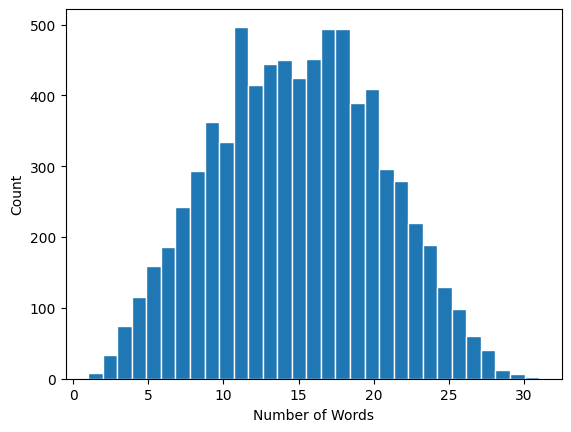

In [7]:
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
train_df["word_count"].max()

plt.hist(train_df['word_count'], bins=31, edgecolor='white')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()

To determine if location is important, I will create a bar chart of the number of disaster and no-disaster tweets from each location. There is some overlap (i.e. USA, New York, United States, etc.). For location "USA", there seems to be a roughly even number of disaster and non-disaster tweets.

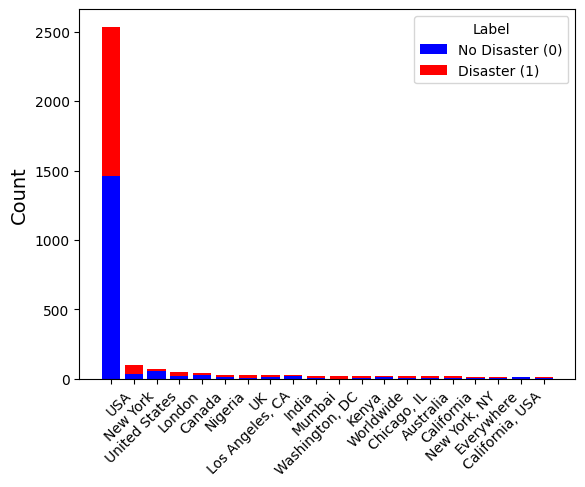

In [8]:
location_target_counts = train_df.groupby(['location', 'target']).size().unstack(fill_value=0)
top_locations = train_df['location'].value_counts().nlargest(20).index
location_target_counts = location_target_counts.loc[top_locations]

plt.bar(location_target_counts.index, location_target_counts[0], label='No Disaster (0)', color='blue')
plt.bar(location_target_counts.index, location_target_counts[1], bottom=location_target_counts[0], label='Disaster (1)', color='red')
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Label', loc='upper right')
plt.show()

Below I changed the y-axis to see the other locations more clearly. There don't seem to be any clear patterns, but some places have a higher proportion of disaster tweets than others. Mumbai and Washington, DC are some examples.

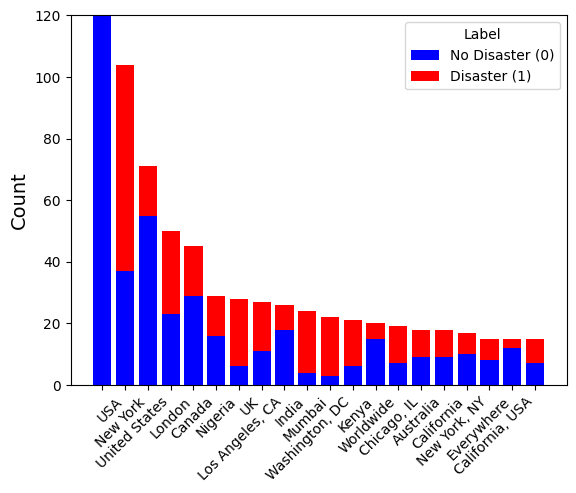

In [9]:
plt.bar(location_target_counts.index, location_target_counts[0], label='No Disaster (0)', color='blue')
plt.bar(location_target_counts.index, location_target_counts[1], bottom=location_target_counts[0], label='Disaster (1)', color='red')
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Label', loc='upper right')
plt.ylim(0, 120)
plt.show()

Now I will clean the text data before analysis. Below is a helper function that removes hashtags, @ usernames, punctation, and URLs. It also makes all words lowercase. I applied this function to both the train and test datasets.

In [10]:
def clean_text(text):
    text = re.sub(r'#', '', text) # remove hashtags
    text = re.sub(r'@\w+', '', text) # remove @ usernames
    text = re.sub(r'[^\w\s]', '', text) # remove punctuation
    text = re.sub(r'http\S+', '', text) # remove URL, identified with 'http'
    text = text.lower() 

    return text

In [11]:
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

Raw text cannot be inputed directly into a machine learning algorithm. To convert raw text into a usable format, I will need to extract features from the raw text. A popular and high performing method for text feature extraction, which I decided to use here, is Text Frequency-Inverse Document Frequency (TF-IDF)[1]. The formula for TF-IDF is shown below:

$$
TF(t,d) = \frac{\text{Number of times term t appears in document d}}{\text{Total number of terms in document d}}
$$

$$
IDF(t,D) = log \frac{\text{Total number of documents D}}{\text{Number of documents containing term t}}
$$

TF-IDF attempts to identify unique and important words that will be useful when building the classifier.

Below, I converted both the train and test datasets using TF-IDF.

In [ ]:
# Vectorize text using TF-IDF

train_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = train_vectorizer.fit_transform(train_df['text'])
X_test_tfidf = train_vectorizer.transform(test_df['text'])

To get a sense of which words the TF-IDF analysis found to be most important, I averaged the TF-IDF score for each word, and selected the top 30 words for visualization.

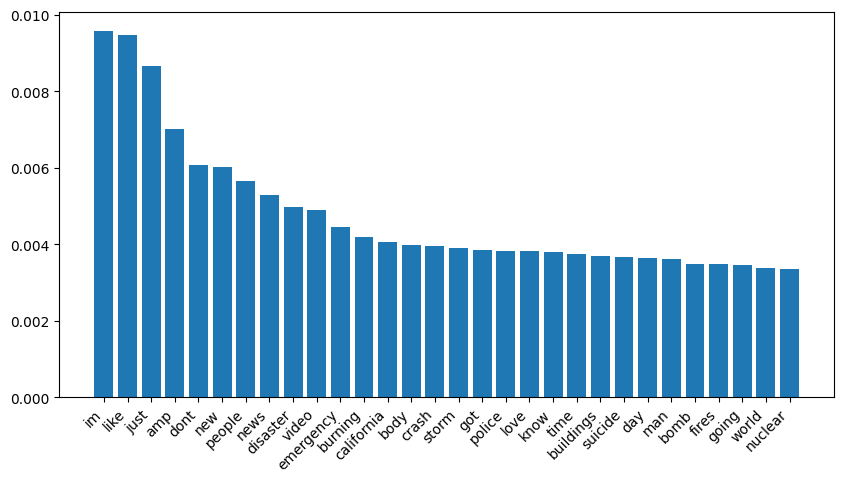

In [ ]:
mean_tfidf_scores = np.asarray(X_train_tfidf.mean(axis=0)).flatten()
tfidf_df = pd.DataFrame({'word': train_vectorizer.get_feature_names_out(), 'mean_tfidf': mean_tfidf_scores})
tfidf_df = tfidf_df.sort_values(by='mean_tfidf', ascending=False)
top30 = tfidf_df.head(30)

plt.figure(figsize=(10, 5))
plt.bar(top30['word'], top30['mean_tfidf'])
plt.xticks(rotation = 45, ha = 'right')
plt.show()

Some words above, such as "disaster", "emergency", "burning", "suicide", "bomb", and "nuclear" might be indicative of a disaster tweet.

Before moving on to training the model, I split the training data into train and validation sets at a 80/20 split.

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf, train_df['target'], test_size=0.2, random_state=456)

### 3. Model Architecture 

TF-IDF word embedding is described above.



I used the `Sequential` function from keras to build the neural network. The input is the features that the TF-IDF generated. From there, I have two layers, one with 128 layers and the other with 64 layers, each using rectified linear activation functions. I also implemented kernel regularization and dropouts to help mitigate potential overfitting. The last layer is 1 neuron using a sigmoid activation function for binary classification.

In [ ]:
model = Sequential()

model.add(Input(shape=(X_train.shape[1],)))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.7))

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.7))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 128)            │     1,994,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,002,817 (7.64 MB)

 Trainable params: 2,002,817 (7.64 MB)

 Non-trainable params: 0 (0.00 B)

I am training the model using the Adam optimizer, with an initial learning rate of 1e-4. I will tune this value later on.

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

In [ ]:
# Train the model

history = model.fit(
    X_train.toarray(), y_train,
    validation_data=(X_val.toarray(), y_val),
    epochs=100,
    batch_size=64,
    verbose=1 
)

Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5231 - loss: 3.3492 - val_accuracy: 0.5870 - val_loss: 1.9386
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5636 - loss: 1.7517 - val_accuracy: 0.5870 - val_loss: 1.3955
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5781 - loss: 1.3426 - val_accuracy: 0.5870 - val_loss: 1.2245
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5598 - loss: 1.2011 - val_accuracy: 0.5870 - val_loss: 1.1301
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5740 - loss: 1.1121 - val_accuracy: 0.5870 - val_loss: 1.0565
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5603 - loss: 1.0434 - val_accuracy: 0.5870 - val_loss: 0.9951
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5660 - loss: 0.9844 - val_accuracy: 0.5870 - val_loss: 0.9427
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5764 - loss: 0.9326 - val_accuracy: 0.5870 - v

From the above output, and the below visualizations, we can see that the train accuracy steadily increases across the 100 epochs. However, the validation accuracy seems to plateau at around 0.8, starting at around epoch 45. This may be indicative of overfitting.

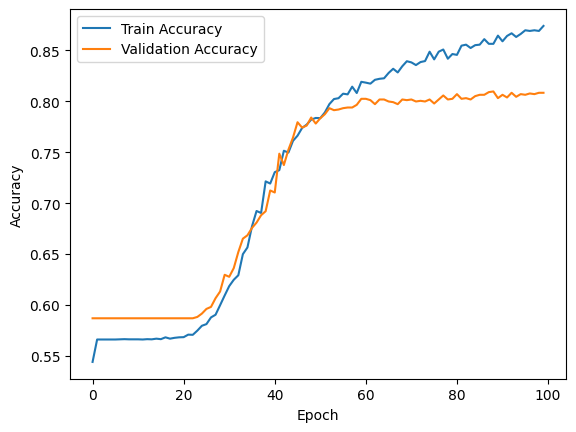

In [69]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Both the train and validation losses decrease rather quickly, and stay low at the higher epochs.

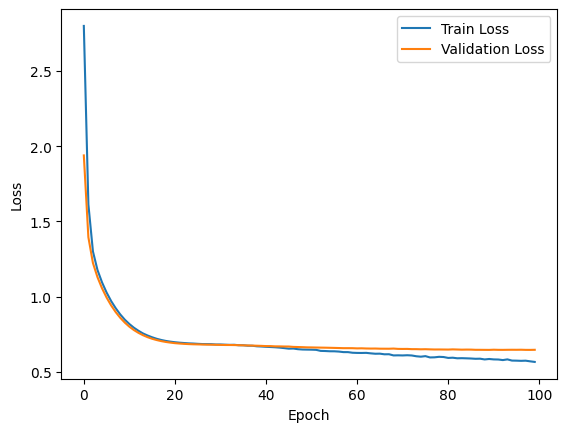

In [70]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 4. Results and Analysis

Since the initial model produced a relatively reasonable validation accuracy of 0.8083, I decided not to change the structure of the model too much, and only tune the learning rate hyperparameter. The initial learning rate was 1e-4. Below, I will try increasing the learning rate to 1e-3, and also decreasing the learning rate to 1e-5, to see if either of these changes improves the model performance.

In [ ]:
# Learning rate: 1e-5

model2 = Sequential()

model2.add(Input(shape=(X_train.shape[1],)))

model2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model2.add(Dropout(0.7))

model2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model2.add(Dropout(0.7))

model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])

history2 = model2.fit(
    X_train.toarray(), y_train,
    validation_data=(X_val.toarray(), y_val),
    epochs=100,
    batch_size=64,
    verbose=1 
)

Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4629 - loss: 3.9986 - val_accuracy: 0.4189 - val_loss: 3.7384
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4581 - loss: 3.6604 - val_accuracy: 0.4314 - val_loss: 3.4346
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4739 - loss: 3.3663 - val_accuracy: 0.4714 - val_loss: 3.1683
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4848 - loss: 3.1082 - val_accuracy: 0.5371 - val_loss: 2.9336
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4973 - loss: 2.8806 - val_accuracy: 0.5890 - val_loss: 2.7263
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5056 - loss: 2.6798 - val_accuracy: 0.6080 - val_loss: 2.5430
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5190 - loss: 2.5017 - val_accuracy: 0.5929 - val_loss: 2.3809
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5159 - loss: 2.3447 - val_accuracy: 0.5916 - v

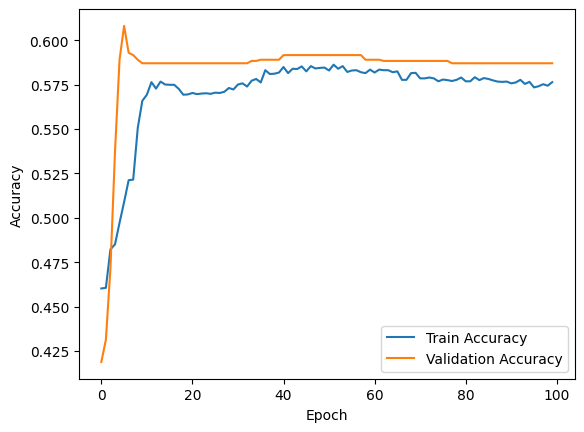

In [85]:
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

It is clear that a learning rate of 1e-5 is far too small. Both the train and validation accuracies seem to plateau fairly quickly at around 0.58, which is much worse than the original model. Here, the model is underfitting.

Next I will try increasing the learning rate to 1e-3.

In [84]:
# Learning rate: 1e-3

model3 = Sequential()

model3.add(Input(shape=(X_train.shape[1],)))

model3.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model3.add(Dropout(0.7))

model3.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model3.add(Dropout(0.7))

model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

history3 = model3.fit(
    X_train.toarray(), y_train,
    validation_data=(X_val.toarray(), y_val),
    epochs=100,
    batch_size=64,
    verbose=1 
)

Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5439 - loss: 1.8280 - val_accuracy: 0.5870 - val_loss: 0.8239
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5649 - loss: 0.7833 - val_accuracy: 0.5870 - val_loss: 0.7064
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5622 - loss: 0.7089 - val_accuracy: 0.5870 - val_loss: 0.6966
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5750 - loss: 0.7030 - val_accuracy: 0.5870 - val_loss: 0.6998
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5740 - loss: 0.7116 - val_accuracy: 0.6106 - val_loss: 0.7147
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6165 - loss: 0.7233 - val_accuracy: 0.6756 - val_loss: 0.7323
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6573 - loss: 0.7433 - val_accuracy: 0.7380 - val_loss: 0.7499
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6993 - loss: 0.7626 - val_accuracy: 0.7360 - v

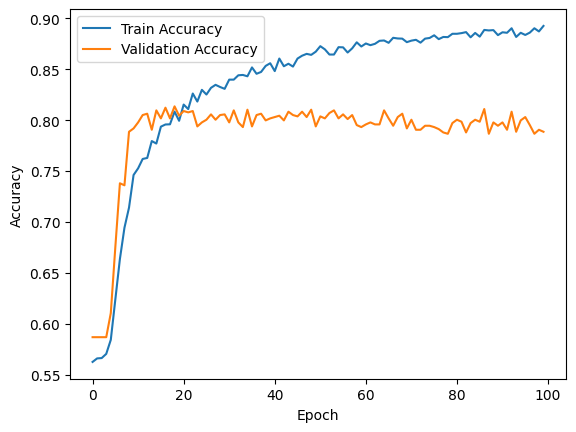

In [86]:
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

With the higher learning rate, the accuracies of both the train and validation sets increases much quicker than before. The train accuracy increases throughout the epochs, but the validation accuracy levels off at 0.8 after about 10 epochs. It even seems to decrease a bit at the later epochs. This higher learning rate seems to have made the previous overfitting issue much worse.

### 5. Conclusion

The original model with learning rate 1e-4 seemed to be the most reasonable, as it produced a validation accuracy around 80% without too severe of overfitting. I will use that model to generate predictions on the test dataset.

In [ ]:
# Generate predictions

y_test_prob = model.predict(X_test_tfidf.toarray())

# Convert to binary

y_test_pred = (y_test_prob > 0.5).astype(int)


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
# Export as csv for kaggle submission

predictions_df = pd.DataFrame({
    'id': test_df['id'],
    'target': y_test_pred.flatten()  # Flatten to convert from 2D to 1D array
})

predictions_df.to_csv("preds.csv", index=False)

<img src='./preds.png'>

The best performing model produced a decent test accuracy of 0.79282, which is comparable to its performance on the validation set.

Overall, I was pleased that the model was able to generate decent predictions based on the tweet text. It's a pleasant surprise for me because these tweets only had an average of about 15 words--that isn't a lot of information to learn from. Regardless, the TF-IDF feature extraction was able to generate some meaningful word matrices for training, and the neural network was (reasonably) succesful at classifying based on those word embeddings.

From the tuning procedure I did, it is clear that learning rate is a very important hyperparamater that can have a significant impact on the model's training. I happened to pick a reasonable learning rate to begin with. Too small a learning rate, and the model did not reach optimal performance after 100 epochs. Too large a learning rate, and the model severely overfit.

In the future, I would like to try other word embedding techniques and generate a model that breaks past the 0.8 validaiton accuracy barrier that I kept running into. I could also try changing the structure of the neural network to make it more or less complex.

### References

1. https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/